In [1]:
import argparse
import json
import os
import pathlib
import sys
from shutil import copyfile
from warnings import simplefilter

from sentence_transformers import models
from typing_extensions import LiteralString

from setfit import SetFitModel, SetFitTrainer
from setfit.data import SAMPLE_SIZES
from setfit.utils import DEV_DATASET_TO_METRIC, LOSS_NAME_TO_CLASS, TEST_DATASET_TO_METRIC, load_data_splits


# ignore all future warnings
simplefilter(action="ignore", category=FutureWarning)

/home/melodia/anaconda3/envs/baselines-setfit/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
parser = argparse.ArgumentParser()
parser.add_argument("--model", default="paraphrase-mpnet-base-v2")
parser.add_argument(
    "--datasets",
    nargs="+",
    default=["sst2"],
)
parser.add_argument("--sample_sizes", type=int, nargs="+", default=SAMPLE_SIZES)
parser.add_argument("--num_iterations", type=int, default=20)
parser.add_argument("--num_epochs", type=int, default=1)
parser.add_argument("--batch_size", type=int, default=16)
parser.add_argument("--max_seq_length", type=int, default=256)
parser.add_argument(
    "--classifier",
    default="logistic_regression",
    choices=[
        "logistic_regression",
        "svc-rbf",
        "svc-rbf-norm",
        "knn",
        "pytorch",
        "pytorch_complex",
    ],
)
parser.add_argument("--loss", default="CosineSimilarityLoss")
parser.add_argument("--exp_name", default="")
parser.add_argument("--add_normalization_layer", default=False, action="store_true")
parser.add_argument("--optimizer_name", default="AdamW")
parser.add_argument("--lr", type=float, default=0.001)
parser.add_argument("--is_dev_set", type=bool, default=False)
parser.add_argument("--is_test_set", type=bool, default=False)
parser.add_argument("--override_results", default=False, action="store_true")
parser.add_argument("--keep_body_frozen", default=False, action="store_true")
parser.add_argument("--add_data_augmentation", default=False)

args = parser.parse_args([])

In [172]:
args.sample_sizes = [8]
args.is_test_set = True

In [173]:
trainers = []

# Configure dataset <> metric mapping. Defaults to accuracy
if args.is_dev_set:
    dataset_to_metric = DEV_DATASET_TO_METRIC
elif args.is_test_set:
    dataset_to_metric = TEST_DATASET_TO_METRIC
else:
    dataset_to_metric = {dataset: "accuracy" for dataset in args.datasets}

# Configure loss function
loss_class = LOSS_NAME_TO_CLASS[args.loss]

for dataset, metric in dataset_to_metric.items():
    if dataset != 'sst5': continue
    x, y, y_text = [], [], []
    few_shot_train_splits, test_data = load_data_splits(dataset, args.sample_sizes, args.add_data_augmentation)

    for split_name, train_data in few_shot_train_splits.items():

        # Load model
        if args.classifier == "pytorch":
            model = SetFitModel.from_pretrained(
                args.model,
                use_differentiable_head=True,
                head_params={"out_features": len(set(train_data["label"]))},
            )
        else:
            model = SetFitModel.from_pretrained(args.model)
        model.model_body.max_seq_length = args.max_seq_length
        if args.add_normalization_layer:
            model.model_body._modules["2"] = models.Normalize()

        # Train on current split
        trainer = SetFitTrainer(
            model=model,
            train_dataset=train_data,
            eval_dataset=test_data,
            metric=metric,
            loss_class=loss_class,
            batch_size=args.batch_size,
            num_epochs=args.num_epochs,
            num_iterations=args.num_iterations,
        )
        if args.classifier == "pytorch":
            trainer.freeze()
            trainer.train()
            trainer.unfreeze(keep_body_frozen=args.keep_body_frozen)
            trainer.train(
                num_epochs=25,
                body_learning_rate=1e-5,
                learning_rate=args.lr,  # recommend: 1e-2
                l2_weight=0.0,
                batch_size=args.batch_size,
            )
        else:
            trainer.train()

        # Evaluate the model on the test data
        metrics = trainer.evaluate()
        print(f"Metrics: {metrics}")
        trainers.append(trainer)
        
    break




============== sst5 ============


Using custom data configuration SetFit--sst5-215b01185f4be506
Reusing dataset json (/home/melodia/.cache/huggingface/datasets/SetFit___json/SetFit--sst5-215b01185f4be506/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)
Using custom data configuration SetFit--sst5-215b01185f4be506
Reusing dataset json (/home/melodia/.cache/huggingface/datasets/SetFit___json/SetFit--sst5-215b01185f4be506/0.0.0/da492aad5680612e4028e7f6ddc04b1dfcec4b64db470ed7cc5f2bb265b9b6b5)
config.json not found in HuggingFace Hub


Test set: 2210


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.66s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.4257918552036199}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.03s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.46199095022624437}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.81s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.4113122171945701}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.28s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.4452488687782805}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.45s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.43800904977375565}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.74s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.47013574660633484}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:11<00:00, 11.14s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.3778280542986425}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.98s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.430316742081448}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:10<00:00, 10.06s/it]
***** Running evaluation *****
config.json not found in HuggingFace Hub


Metrics: {'accuracy': 0.4497737556561086}


model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
***** Running training *****
  Num examples = 1600
  Num epochs = 1
  Total optimization steps = 100
  Total train batch size = 16
Epoch: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:12<00:00, 12.15s/it]
***** Running evaluation *****


Metrics: {'accuracy': 0.49366515837104075}


In [174]:
x = trainer.eval_dataset["text"]
y = trainer.eval_dataset["label"]
y_text = trainer.eval_dataset['label_text']

In [7]:
import pandas as pd

In [175]:
pd.DataFrame(y_text).value_counts()

negative         633
positive         510
very positive    399
neutral          389
very negative    279
dtype: int64

In [176]:
pd.DataFrame(y).value_counts()

1    633
3    510
4    399
2    389
0    279
dtype: int64

In [177]:
# for item in pd.DataFrame(y_text).value_counts().index:
#     print(item[0])
classes = [None] * pd.DataFrame(y_text).value_counts().size
for k, v in zip(pd.DataFrame(y).value_counts().index, pd.DataFrame(y_text).value_counts().index):
    classes[k[0]] = v[0]
classes

['very negative', 'negative', 'neutral', 'positive', 'very positive']

In [178]:
y_preds = []
for trainer in trainers:
    y_preds.append(trainer.model.predict(x))

In [25]:
import numpy as np
import sklearn

In [40]:
(y_pred==y).mean()

0.488

In [24]:
x[1232], y[1232], y_pred[1232]

('i reckon you need to stop feeling bitter and be realistic', 3, 0)

In [73]:
sklearn.metrics.confusion_matrix(y, y_preds[9], normalize='true')

array([[0.47, 0.07, 0.05, 0.2 , 0.17, 0.05],
       [0.05, 0.41, 0.3 , 0.06, 0.08, 0.1 ],
       [0.08, 0.16, 0.42, 0.12, 0.09, 0.13],
       [0.16, 0.05, 0.07, 0.55, 0.07, 0.09],
       [0.09, 0.06, 0.01, 0.07, 0.58, 0.19],
       [0.06, 0.15, 0.03, 0.03, 0.18, 0.55]])

In [86]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(cm, savename, title='Confusion Matrix'):

    plt.figure(figsize=(12, 8), dpi=100)
    np.set_printoptions(precision=2)

    # 在混淆矩阵中每格的概率值
    ind_array = np.arange(len(classes))
    x, y = np.meshgrid(ind_array, ind_array)
    for x_val, y_val in zip(x.flatten(), y.flatten()):
        c = cm[y_val][x_val]
        if c > 0.001:
            plt.text(x_val, y_val, "%0.2f" % (c,), color='red', fontsize=15, va='center', ha='center')
    
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.binary, vmax=1, vmin=0)
    plt.title(title)
    plt.colorbar()
    xlocations = np.array(range(len(classes)))
    plt.xticks(xlocations, classes, rotation=90)
    plt.yticks(xlocations, classes)
    plt.ylabel('Actual label')
    plt.xlabel('Predict label')
    
    # offset the tick
    tick_marks = np.array(range(len(classes))) + 0.5
    plt.gca().set_xticks(tick_marks, minor=True)
    plt.gca().set_yticks(tick_marks, minor=True)
    plt.gca().xaxis.set_ticks_position('none')
    plt.gca().yaxis.set_ticks_position('none')
    plt.grid(True, which='minor', linestyle='-')
    plt.gcf().subplots_adjust(bottom=0.15)
    
    # show confusion matrix
#     plt.savefig(savename, format='png')
    plt.show()

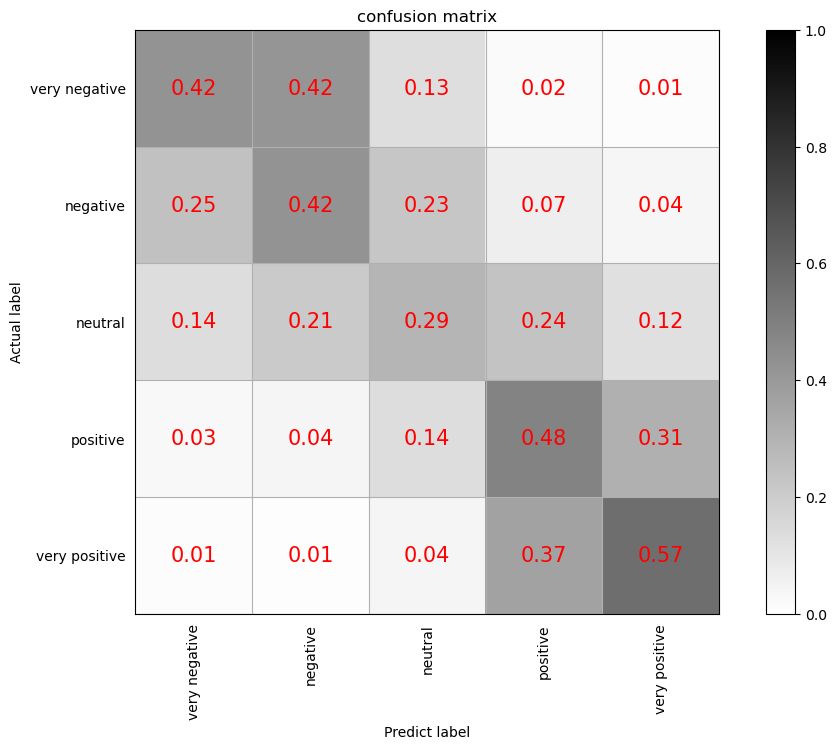

In [180]:
classes = classes
cm = 0
for i in range(10):
    cm += sklearn.metrics.confusion_matrix(y, y_preds[i], normalize='true')
cm = cm/10
plot_confusion_matrix(cm, None, title='confusion matrix')

In [233]:
# idx = 1115
idx += 1
print(idx)

print(x[idx])
for i in range(10):
#     print(classes[y_preds[i][idx]], end=' | ')
    print(y_preds[i][idx], end=' ')
print('')
print(y[idx])

1134
it would be hard to think of a recent movie that has worked this hard to achieve this little fun .
4 2 2 4 3 2 2 2 2 3 
0


In [270]:
dataset_names = ['sst5', 'amazon_counterfactual_en', 'SentEval-CR', 'emotion', 'enron_spam', 'ag_news']

all_reses = {}
for dataset_name in dataset_names:
    reses = []
    for i in range(10):
        path = 'results/paraphrase-mpnet-base-v2-CosineSimilarityLoss-logistic_regression-iterations_20-batch_16/{}/train-64-{}/results.json'.format(dataset_name, i)
        with open(path, 'r') as f:
            res = json.load(f)
        reses.append((res['score']))
    all_reses[dataset_name] = reses

In [246]:
for dataset_name in dataset_names:
    reses = all_reses[dataset_name]
    print(dataset_name, np.mean(reses), np.std(reses))

sst5 52.43891402714932 0.351924513219017
amazon_counterfactual_en 61.06590232409148 2.178507012181265
SentEval-CR 90.62416998671979 0.8772985160644741
emotion 76.16000000000001 1.6230834852218776
enron_spam 96.11999999999999 0.7733692520394149
ag_news 88.25526315789473 0.48819867896022207


In [271]:
means = []
stds = []
s = ''
for name in dataset_names:
#     s += '\\textbf{' + name + '}' + ' & '
#     s += '}'
    reses = all_reses[name]
    s += '{:.1f}'.format(np.mean(reses)) + '\\tiny{' + '{:.1f}'.format(np.std(reses)) + '} & '
    if 'ag' not in name:
        means.append(np.mean(reses))
        stds.append(np.std(reses))
s += '{:.1f}'.format(np.mean(means)) + '\\tiny{' + '{:.1f}'.format(np.mean(stds)) + '} & '
print(s)

52.4\tiny{0.4} & 61.1\tiny{2.2} & 90.6\tiny{0.9} & 76.2\tiny{1.6} & 96.1\tiny{0.8} & 88.3\tiny{0.5} & 75.3\tiny{1.2} & 


In [281]:
path = '/home/melodia/proj/11711/hw3/setfit/scripts/tfew/results/t03b_pretrained/amazon_counterfactual_en/train-8-9/seed0/dev_scores.json'
with open(path, 'r') as f:
    res = json.load(f)
res

{'matthews_correlation': 0.05396449375577921,
 'score_gt': 1.1481514785289764,
 'score_cand': 1.610328781619668}

In [320]:
x1 = 'each'
all_reses = {}
lgs = ['En', 'De', 'Ja', 'Zh', 'Fr', 'Es']
for lg in lgs:
    reses = []
    for i in range(10):
        path = 'results/sentence-transformers-paraphrase-multilingual-mpnet-base-v2-CosineSimilarityLoss-logistic_regression-epochs_20-batch_16/amazon_reviews_multi_{}/{}/train-8-{}/results.json'.format(lg.lower(), x1, i)
        with open(path, 'r') as f:
            res = json.load(f)
        reses.append(res['score'])
    all_reses[lg] = reses

In [321]:
means = []
stds = []
s = '{} & '.format(x1)
for name in lgs:
    reses = all_reses[name]
    s += '{:.1f}'.format(np.mean(reses)) + '\\tiny{' + '{:.1f}'.format(np.std(reses)) + '} & '
    means.append(np.mean(reses))
    stds.append(np.std(reses))
s += '{:.1f}'.format(np.mean(means)) + '\\tiny{' + '{:.1f}'.format(np.mean(stds)) + '} & '
print(s)

each & 84.5\tiny{6.5} & 78.8\tiny{2.7} & 93.5\tiny{6.2} & 93.7\tiny{3.6} & 85.1\tiny{4.7} & 79.4\tiny{4.5} & 85.8\tiny{4.7} & 


In [311]:
(83+84+97.1+97.4+83.5+84.9)/6

88.31666666666666